# Loading data

In [81]:
%cd ~/Documents/code/projects/tarsila/braz-speech-pipeline
from src.utils.database import Database

/Users/64926/Documents/code/projects/tarsila/braz-speech-pipeline


In [82]:
with Database() as db:
    users = db._run_query("SELECT * FROM users where designated_corpus_id is not null and data_inicio is not null")
    transcription_times = db._run_query(
        f"""
            SELECT TimeValidated.id as transcription_id, TimeValidated.user_validated as username, TimeValidated.duration as transcription_duration,  TimeValidated.time_validated as transcription_time, TimeValidated.answer as transcription_description , Dataset.* 
            FROM TimeValidated 
            INNER JOIN Dataset ON TimeValidated.id_data = Dataset.id 
            WHERE TimeValidated.user_validated IN {tuple(users['username'].to_list())} 
            AND TimeValidated.time_validated > '2023-06-04 00:00:00'
        """)

# Creating dataset for analysis

In [83]:
transcription_times["transcription_multiple"] = transcription_times["transcription_duration"] / (transcription_times["audio_lenght"] / 16E3)
transcription_times["segment_duration"] = (transcription_times["audio_lenght"] / 16E3).round(2)
transcription_times["transcription_multiple"] = transcription_times["transcription_multiple"].apply(lambda x: int(x))
transcription_times["transcription_duration_in_minutes"] = (transcription_times["transcription_duration"] / 60).round(2)
df = transcription_times[["id", "transcription_id", "transcription_time", "username","transcription_duration", "segment_duration", "transcription_multiple", "transcription_duration_in_minutes"]]

In [84]:
df

,id,transcription_id,transcription_time,username,transcription_duration,segment_duration,transcription_multiple,transcription_duration_in_minutes
0,1063285,1263086,2023-06-05 08:30:44,jess.laureano@usp.br,180,6.45,27,3.00
1,1063286,1263087,2023-06-05 08:33:16,jess.laureano@usp.br,152,10.81,14,2.53
2,1063287,1263088,2023-06-05 08:34:49,jess.laureano@usp.br,92,10.43,8,1.53
3,1063287,1263089,2023-06-05 08:37:34,jess.laureano@usp.br,165,10.43,15,2.75
4,1063288,1263090,2023-06-05 08:42:21,jess.laureano@usp.br,180,10.65,16,3.00
...,...,...,...,...,...,...,...,...
204847,1369444,1468431,2023-09-25 19:51:03,aluisioriosjulia@gmail.com,19,2.92,6,0.32
204848,1369445,1468432,2023-09-25 19:51:24,aluisioriosjulia@gmail.com,20,2.12,9,0.33
204849,1369446,1468433,2023-09-25 19:51:42,aluisioriosjulia@gmail.com,17,3.24,5,0.28
204850,1369447,1468434,2023-09-25 19:51:48,aluisioriosjulia@gmail.com,5,3.82,1,0.08


# Cleaning data

In [85]:
# Let's remove bonus times, like holidays
df = df[df["id"] != 1]

# # Select only the times after new hour calculation
df = df[df.transcription_time >= "2023-07-24 00:00:00"]
# df = df[df.transcription_time >= "2023-09-25 00:00:00"]

df.transcription_duration_in_minutes_rounded = df.transcription_duration_in_minutes.round(0)

# Analysis

### Segment sizes

As we can see, there isn't significant differences on the segment durations among the uses.

<Axes: xlabel='username'>

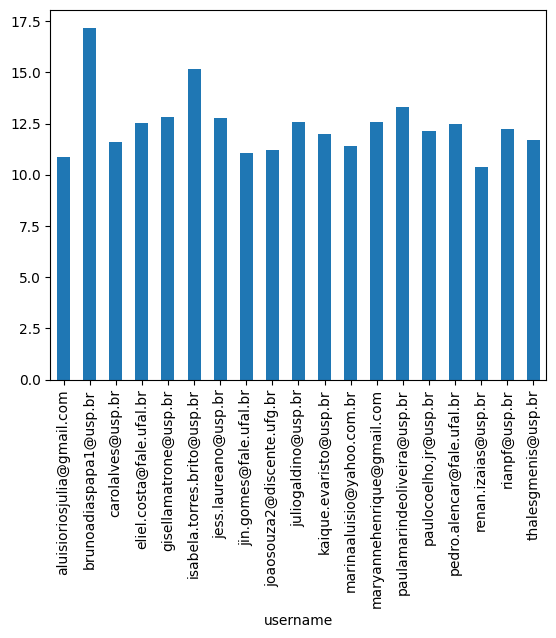

In [86]:
df.groupby("username")["segment_duration"].quantile(0.95).plot(kind="bar")

However, we can notice a difference on the transcription duration, and on the multiple (the rate between the transcription duration and the segment duration).

<Axes: xlabel='username'>

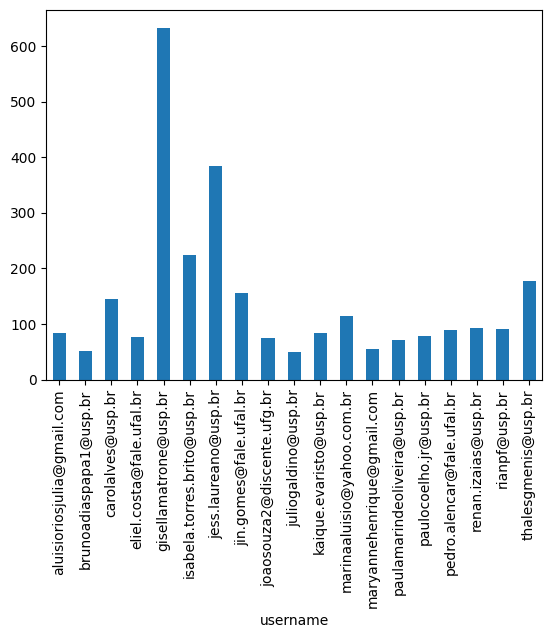

In [87]:
df.groupby("username")["transcription_duration"].quantile(0.95).plot(kind="bar")

<Axes: xlabel='username'>

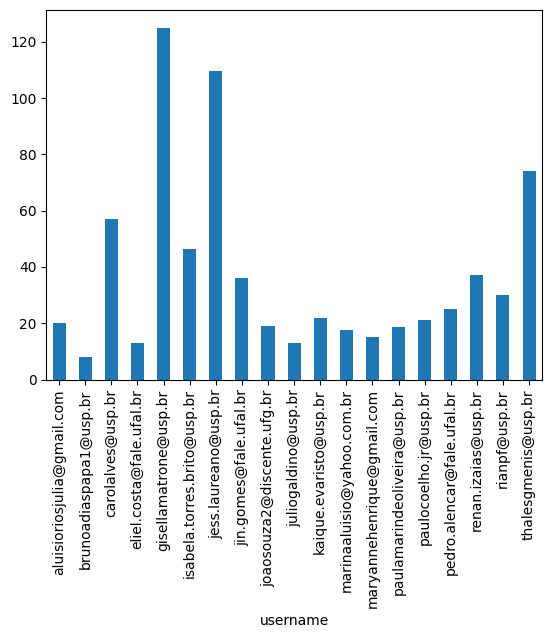

In [88]:
df.groupby("username")["transcription_multiple"].quantile(0.95).plot(kind="bar")

### Outlier detection

<Axes: xlabel='username', ylabel='transcription_duration_in_minutes'>

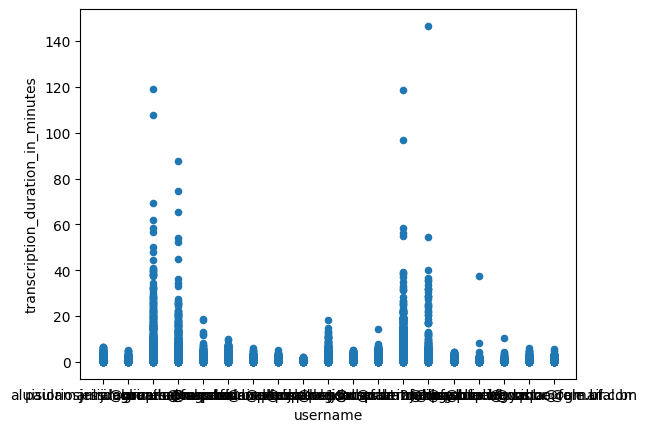

In [89]:
df.plot.scatter(x="username", y="transcription_duration_in_minutes")

transcription_duration                  Axes(0.125,0.53;0.352273x0.35)
transcription_duration_in_minutes    Axes(0.547727,0.53;0.352273x0.35)
segment_duration                        Axes(0.125,0.11;0.352273x0.35)
transcription_multiple               Axes(0.547727,0.11;0.352273x0.35)
dtype: object

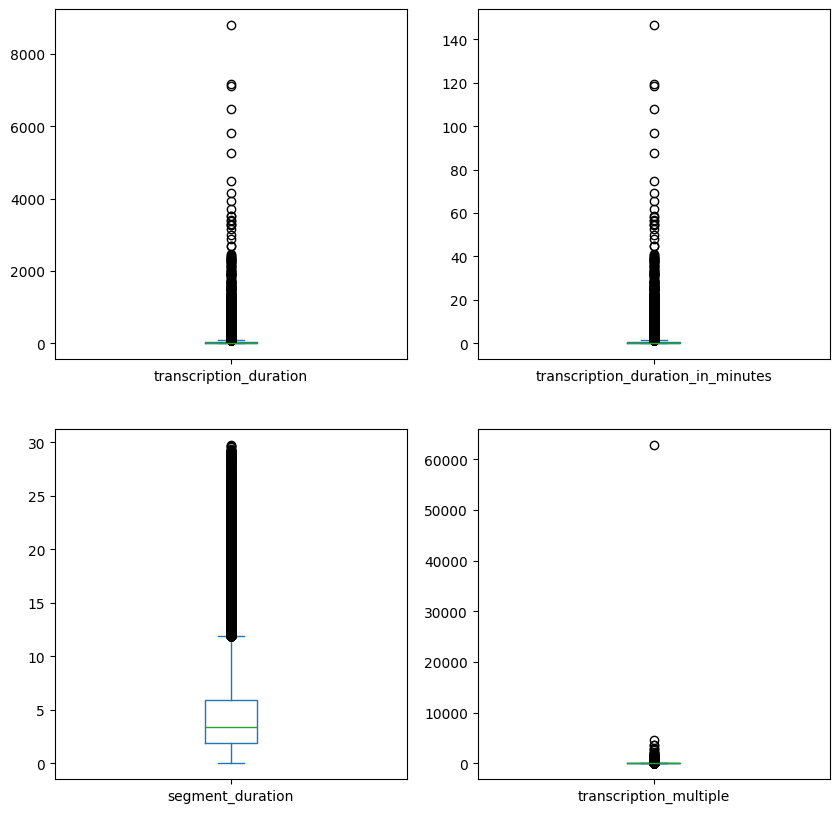

In [90]:
df[["transcription_duration", "transcription_duration_in_minutes", "segment_duration", "transcription_multiple"]].plot(kind="box", subplots=True, layout=(2,2), figsize=(10,10))

In [91]:
import numpy as np
from scipy import stats

z_scores = stats.zscore(df[["transcription_duration", "transcription_multiple"]])
z_scores

,transcription_duration,transcription_multiple
88751,1.059894,0.045870
88752,0.037187,-0.027973
88753,-0.147874,-0.027973
88754,-0.069953,0.019497
88755,-0.293975,0.003674
...,...,...
204847,-0.167354,-0.027973
204848,-0.157614,-0.012150
204849,-0.186834,-0.033248
204850,-0.303715,-0.054346


In [92]:
# Convert the z-scores to absolute values
abs_z_scores = np.abs(z_scores)

# Select data points with a z-scores above or below 3
filtered_entries = (abs_z_scores > 3).any(axis=1)

# Filter the dataset
outliers_df = df[filtered_entries]

outliers_df

,id,transcription_id,transcription_time,username,transcription_duration,segment_duration,transcription_multiple,transcription_duration_in_minutes
89024,1072969,1352277,2023-07-24 13:33:31,jess.laureano@usp.br,349,11.27,30,5.82
89307,1068079,1352560,2023-07-24 16:32:37,kaique.evaristo@usp.br,501,15.45,32,8.35
90456,1061415,1353709,2023-07-25 07:51:44,jin.gomes@fale.ufal.br,347,10.49,33,5.78
90823,1073178,1354076,2023-07-25 12:08:32,jess.laureano@usp.br,178,0.22,805,2.97
90836,1073183,1354089,2023-07-25 12:15:06,jess.laureano@usp.br,83,0.08,1037,1.38
...,...,...,...,...,...,...,...,...
203384,1368642,1466968,2023-09-25 11:07:32,aluisioriosjulia@gmail.com,23,0.02,1153,0.38
203577,1174654,1467161,2023-09-25 11:48:08,jess.laureano@usp.br,563,5.02,112,9.38
203633,1174660,1467217,2023-09-25 11:59:08,jess.laureano@usp.br,595,3.46,171,9.92
203707,1174668,1467291,2023-09-25 12:17:35,jess.laureano@usp.br,934,19.66,47,15.57


### User profile on transcriptions

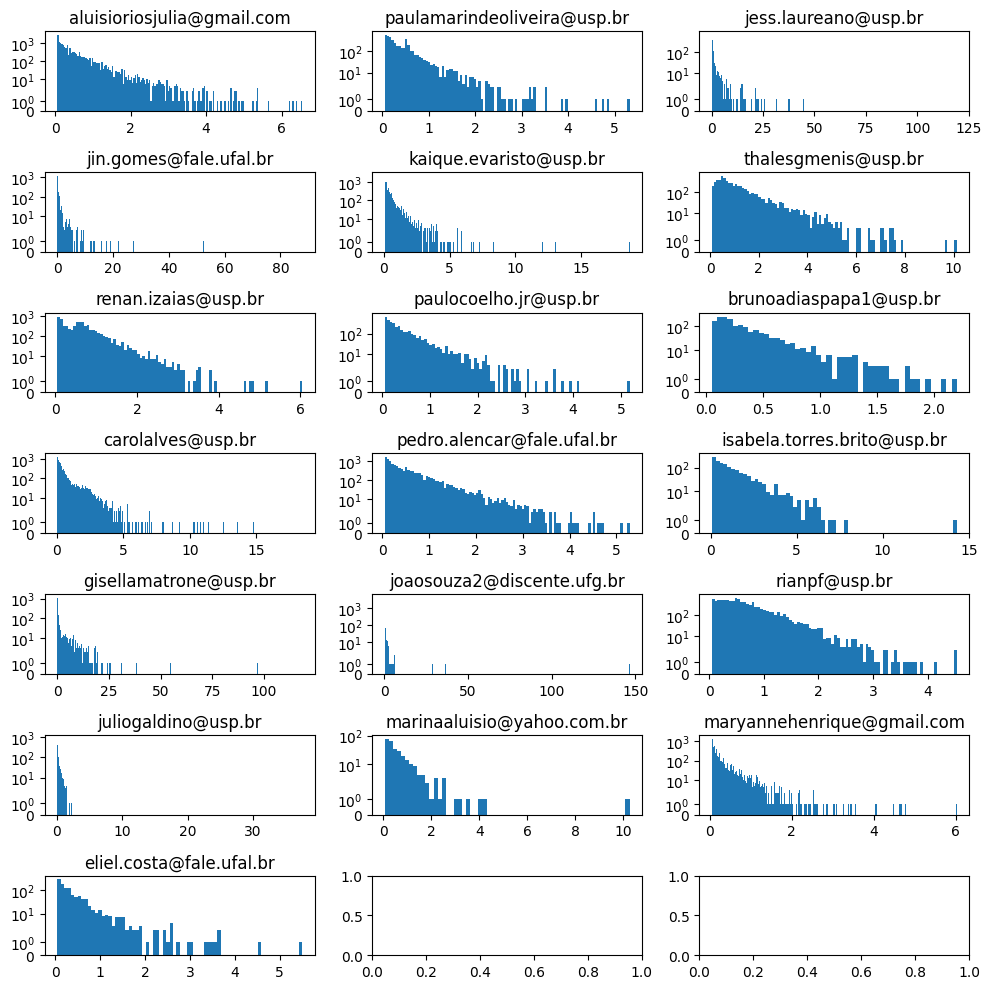

In [93]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=3, nrows= int(len(df["username"].unique())/3) + 1, figsize=(10,10))

for idx, user in enumerate(df["username"].unique()):
    ax[int(idx/3), idx%3].hist(df[df["username"] == user]["transcription_duration_in_minutes"], bins="auto")
    ax[int(idx/3), idx%3].set_title(user)
    ax[int(idx/3), idx%3].set_yscale("symlog")
# Adjust the spacing between subplots
fig.tight_layout()
# # Remove the empty subplot in the last row and last column
# fig.delaxes(ax[6, 1])
# fig.delaxes(ax[6, 2])

# Display the plot
plt.show()
    

<Axes: xlabel='segment_duration', ylabel='username'>

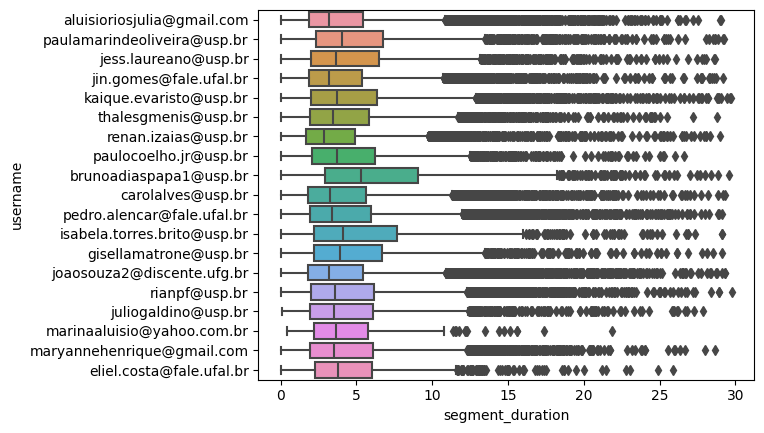

In [94]:
import seaborn as sns

sns.boxplot(data=df, x="segment_duration", y="username")


<Axes: xlabel='transcription_duration_in_minutes', ylabel='username'>

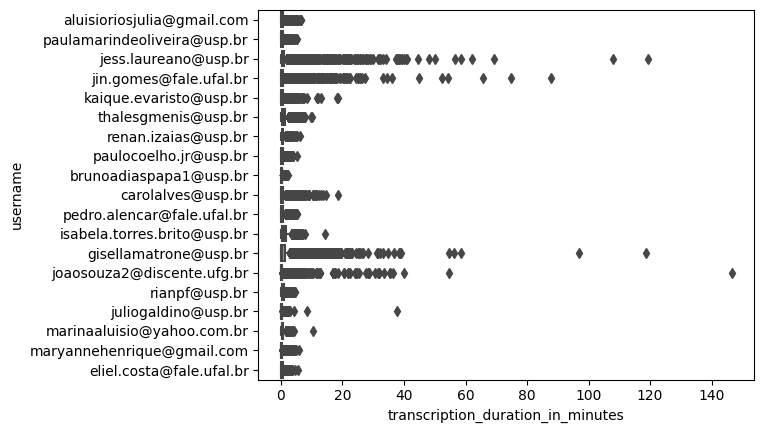

In [95]:
sns.boxplot(data=df, x="transcription_duration_in_minutes", y="username")


In [110]:
df[(df["transcription_duration_in_minutes"] > 15)].groupby(["username"])["transcription_duration_in_minutes"].sum()/60

username
carolalves@usp.br              0.307500
gisellamatrone@usp.br         32.310667
jess.laureano@usp.br          39.127333
jin.gomes@fale.ufal.br        20.032500
joaosouza2@discente.ufg.br    15.531167
juliogaldino@usp.br            0.626333
kaique.evaristo@usp.br         0.614167
Name: transcription_duration_in_minutes, dtype: float64

<Axes: xlabel='transcription_duration_in_minutes', ylabel='username'>

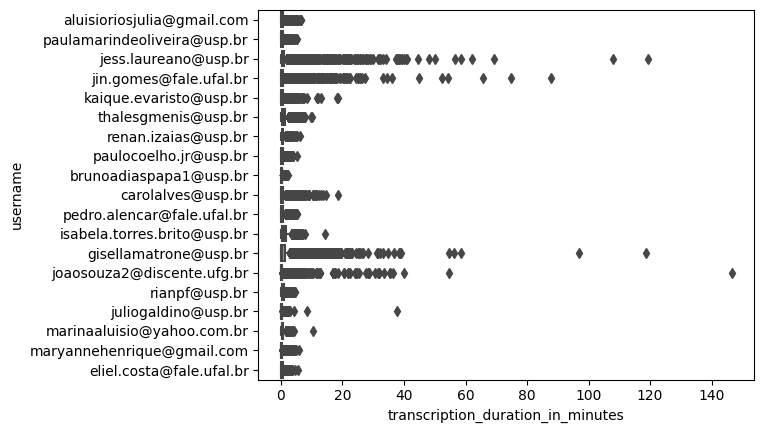

In [96]:
sns.boxplot(data=df, x="transcription_duration_in_minutes", y="username")


In [100]:
df.groupby("username")["transcription_duration_in_minutes"].quantile(0.99)

username
aluisioriosjulia@gmail.com      2.6200
brunoadiaspapa1@usp.br          1.4345
carolalves@usp.br               4.1793
eliel.costa@fale.ufal.br        2.6200
gisellamatrone@usp.br          21.6072
isabela.torres.brito@usp.br     5.6692
jess.laureano@usp.br           25.2830
jin.gomes@fale.ufal.br          9.9853
joaosouza2@discente.ufg.br      3.2000
juliogaldino@usp.br             1.6000
kaique.evaristo@usp.br          2.8000
marinaaluisio@yahoo.com.br      3.6175
maryannehenrique@gmail.com      1.8200
paulamarindeoliveira@usp.br     2.0500
paulocoelho.jr@usp.br           2.1610
pedro.alencar@fale.ufal.br      2.5300
renan.izaias@usp.br             2.4000
rianpf@usp.br                   2.2300
thalesgmenis@usp.br             4.6915
Name: transcription_duration_in_minutes, dtype: float64